In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !git clone https://github.com/bhagwatgarg/ECCV2022-RIFE

# %cd ECCV2022-RIFE/
# !pip install scikit-video
# !pip3 install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skvideo.io
import skimage



import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from model.warplayer import warp
from model.refine import *



In [3]:
from model.RIFE import Model
model = Model()
model.load_model('train_log', -1)

/Users/bhagwat/miniconda3/envs/conda-DestVI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bhagwat/miniconda3/envs/conda-DestVI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /Users/bhagwat/miniconda3/envs/conda-DestVI/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <5B3E6F5D-79A8-320C-BB50-9EDE6B0839DA> /Users/bhagwat/miniconda3/envs/conda-DestVI/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [4]:
for name, param in model.flownet.named_parameters():
    # param.requires_grad = False
    if name.find('block3') == 0:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [5]:
summary(model.flownet, (6, 480, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 120, 60, 80]           6,600
             PReLU-2          [-1, 120, 60, 80]             120
            Conv2d-3          [-1, 240, 30, 40]         259,440
             PReLU-4          [-1, 240, 30, 40]             240
            Conv2d-5          [-1, 240, 30, 40]         518,640
             PReLU-6          [-1, 240, 30, 40]             240
            Conv2d-7          [-1, 240, 30, 40]         518,640
             PReLU-8          [-1, 240, 30, 40]             240
            Conv2d-9          [-1, 240, 30, 40]         518,640
            PReLU-10          [-1, 240, 30, 40]             240
           Conv2d-11          [-1, 240, 30, 40]         518,640
            PReLU-12          [-1, 240, 30, 40]             240
           Conv2d-13          [-1, 240, 30, 40]         518,640
            PReLU-14          [-1, 240,

In [6]:
videodata_ = skvideo.io.vread("sample.mp4", num_frames=15)
videodata_.shape

(15, 720, 1280, 3)

In [7]:
i_width = 640
i_height = 480
videodata=np.zeros((videodata_.shape[0], i_height, i_width, 3))
for i in range(videodata_.shape[0]):
  videodata[i]=np.float32(skimage.transform.resize(videodata_[i], (i_height, i_width)))
videodata.shape

(15, 480, 640, 3)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def process_frame(arr):
  img0=(torch.tensor(arr.transpose(2, 0, 1), dtype=torch.float32).to(device)).unsqueeze(0)
  n, c, h, w = img0.shape
  ph = ((h - 1) // 32 + 1) * 32
  pw = ((w - 1) // 32 + 1) * 32
  padding = (0, pw - w, 0, ph - h)
  img0 = F.pad(img0, padding)
  return img0

def post_process(img):
  return img.cpu().detach().numpy().transpose(1, 2, 0)

In [9]:
frames=[0, 10, 5]
img0=process_frame(videodata[frames[0]])
img1=process_frame(videodata[frames[1]])
img_mid_actual=process_frame(videodata[frames[2]])

In [10]:
img0.shape

torch.Size([1, 3, 480, 640])

In [11]:
img_mid_pred=model.inference(img0, img1)

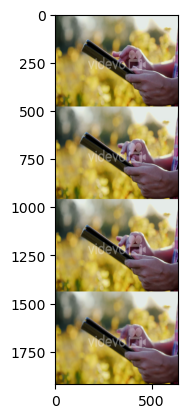

In [12]:
plt.imshow(np.concatenate([post_process(img0[0]), post_process(img1[0]), post_process(img_mid_actual[0]), post_process(img_mid_pred[0])]))

In [13]:
def get_ith_frame(data, i):
  img0=process_frame(data[i])
  img1=process_frame(data[i+2])
  img_mid_actual=process_frame(data[i+1])
  return torch.cat([img0, img1], dim=1), img_mid_actual

In [14]:
train_X, train_Y=None, None

for i in range(5):
    i_X, i_Y = get_ith_frame(videodata, i)
    if train_X==None:
        train_X, train_Y = i_X, i_Y
    else:
        train_X, train_Y = torch.cat([train_X, i_X]), torch.cat([train_Y, i_Y])

In [15]:
train_X.shape, train_Y.shape

(torch.Size([5, 6, 480, 640]), torch.Size([5, 3, 480, 640]))

In [16]:
res=model.update(train_X, train_Y, learning_rate=0.001, training=False)
print(res[1]['total_loss'])

tensor(0.0132, grad_fn=<AddBackward0>)


In [20]:
res=model.update(train_X, train_Y, learning_rate=0.001, training=True)
print(res[1]['total_loss'])

tensor(0.0126, grad_fn=<AddBackward0>)


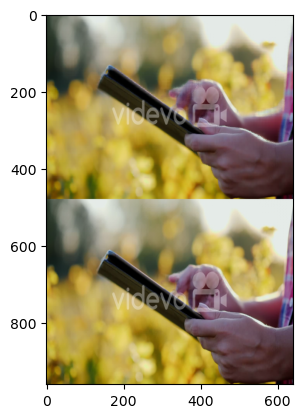

In [21]:
img_mid_pred_2=model.inference(img0, img1)
plt.imshow(np.concatenate([post_process(img_mid_pred[0]), post_process(img_mid_pred_2[0])]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


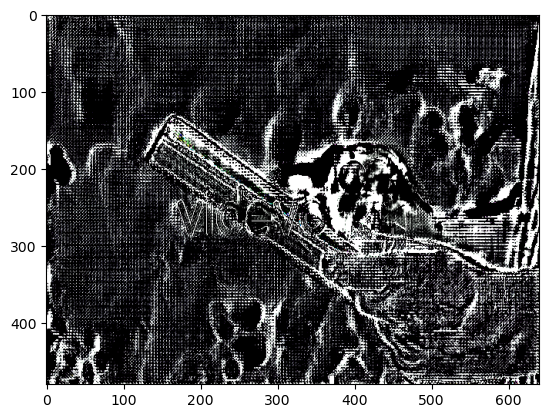

In [22]:
diff=(post_process(img_mid_pred[0])-post_process(img_mid_pred_2[0]))
plt.imshow(((diff)*255))